<a href="https://colab.research.google.com/github/thunderstorm25/goo_cola/blob/main/joke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (5682, 41)

Missing values per column:
marking         5682
player             0
curve              0
balance            0
sprint_speed       0
agility            0
jumping            0
heading            0
shot_power         0
finishing          0
dtype: int64

Correlations with player value:
attacking_quotient: correlation = 0.281, p-value = 1.237e-103
defensive_quotient: correlation = 0.119, p-value = 3.109e-19
technical_ability: correlation = 0.291, p-value = 5.845e-111
physical_prowess: correlation = 0.222, p-value = 4.226e-64
age: correlation = 0.079, p-value = 2.020e-09
experience_factor: correlation = 0.079, p-value = 2.099e-09

Logistic Regression Performance:
accuracy: 0.8629
precision: 0.8501
recall: 0.8820
f1_score: 0.8657
confusion_matrix:
[[918 170]
 [129 964]]

Random Forest Performance:
accuracy: 0.9578
precision: 0.9417
recall:

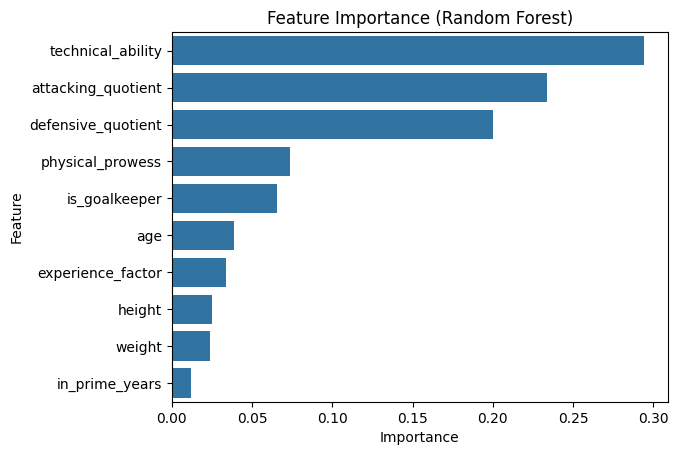

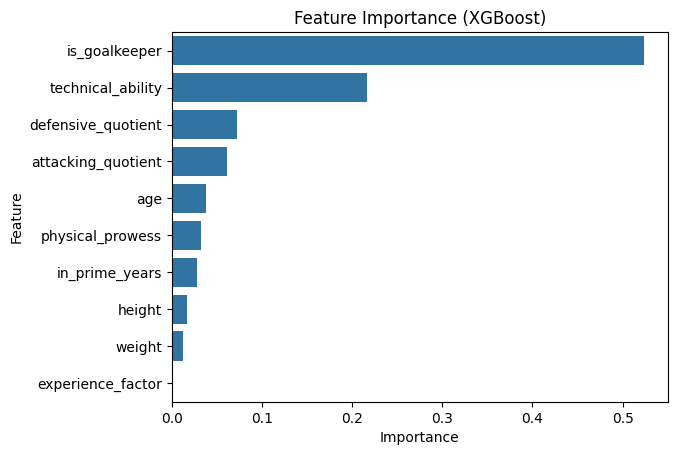

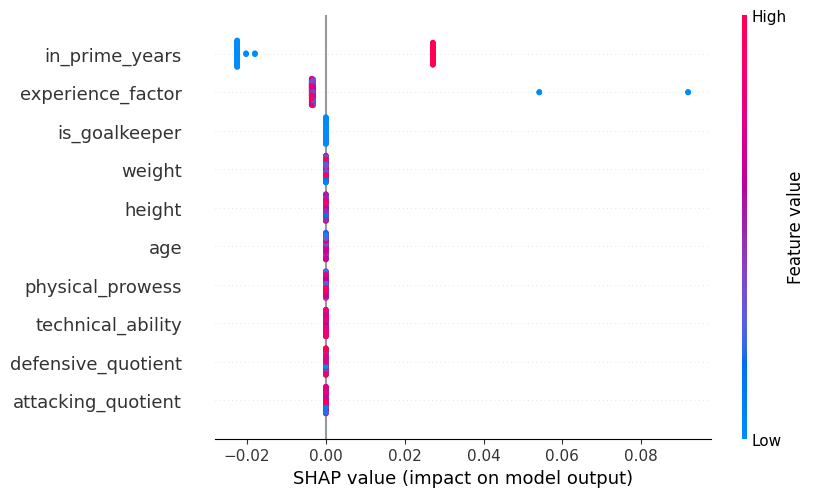


High Performer Sample Prediction:
Logistic Regression: High Performer (Probability: 0.9515)
Random Forest: High Performer (Probability: 0.9900)
XGBoost: High Performer (Probability: 0.9996)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import pearsonr
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap

# Load dataset
file_path = '/content/drive/MyDrive/dataset/player_stats.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# --- Data Preprocessing ---
print("Dataset shape:", df.shape)
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

# Fill missing 'marking' values by position average
positions = df.groupby('att_position')['marking'].mean().to_dict()
df['marking'] = df.apply(lambda x: positions.get(x['att_position']) if pd.isna(x['marking']) else x['marking'], axis=1)

# Convert 'value' to numeric (handling M, K, €)
df['value'] = df['value'].str.replace(r'[€$]', '', regex=True)
df['value'] = df['value'].str.replace(r'\.', '', regex=True)
df['value'] = df['value'].str.replace('M', '000000', regex=True)
df['value'] = df['value'].str.replace('K', '000', regex=True)
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# Fill missing 'value' with position-wise median
if df['value'].isna().sum() > 0:
    position_value_median = df.groupby('att_position')['value'].median()
    df['value'] = df.apply(lambda x: position_value_median.get(x['att_position']) if pd.isna(x['value']) else x['value'], axis=1)

# --- Feature Engineering ---
df['attacking_quotient'] = df[['finishing', 'shot_power', 'long_shots', 'volleys', 'penalties', 'att_position', 'ball_control', 'dribbling']].mean(axis=1)
df['defensive_quotient'] = df[['marking', 'stand_tackle', 'slide_tackle', 'interceptions', 'aggression']].mean(axis=1)
df['technical_ability'] = df[['ball_control', 'dribbling', 'short_pass', 'long_pass']].mean(axis=1)
df['physical_prowess'] = df[['strength', 'stamina', 'sprint_speed', 'jumping']].mean(axis=1)

df['is_goalkeeper'] = df[['gk_positioning', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes']].mean(axis=1) > 70
df['in_prime_years'] = (df['age'] >= 25) & (df['age'] <= 29)
df['experience_factor'] = (df['age'] - 18).clip(lower=0)

# Correlation with value
print("\nCorrelations with player value:")
features_corr = ['attacking_quotient', 'defensive_quotient', 'technical_ability', 'physical_prowess', 'age', 'experience_factor']
for feature in features_corr:
    corr, p_value = pearsonr(df[feature], df['value'])
    print(f"{feature}: correlation = {corr:.3f}, p-value = {p_value:.3e}")

# --- Target Variable ---
value_threshold = df['value'].quantile(0.75)
df['high_performer'] = df['value'] > value_threshold

# --- Feature Selection ---
features = ['attacking_quotient', 'defensive_quotient', 'technical_ability', 'physical_prowess',
            'age', 'height', 'weight', 'experience_factor', 'in_prime_years', 'is_goalkeeper']

X = df[features]
y = df['high_performer']

# --- Handle Class Imbalance ---
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

# --- Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42)
}

# --- Training and Evaluation ---
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    print(f"\n{name} Performance:")
    for metric, value in results[name].items():
        if metric == 'confusion_matrix':
            print(f"{metric}:\n{value}")
        else:
            print(f"{metric}: {value:.4f}")

# --- Visual Comparison ---
metrics_df = pd.DataFrame({
    model: [results[model][metric] for metric in ['accuracy', 'precision', 'recall', 'f1_score']]
    for model in results
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# --- Feature Importance - Random Forest ---
rf_model = models['Random Forest']
feature_importance_rf = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance_rf)
plt.title('Feature Importance (Random Forest)')
plt.show()

# --- Feature Importance - XGBoost ---
xgb_model = models['XGBoost']
feature_importance_xgb = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance_xgb)
plt.title('Feature Importance (XGBoost)')
plt.show()

# Ensure all columns are numeric (convert booleans to int)
X_train_shap = X_train.copy()
X_test_shap = X_test.copy()

for col in X_train_shap.columns:
    if X_train_shap[col].dtype == 'bool':
        X_train_shap[col] = X_train_shap[col].astype(int)
        X_test_shap[col] = X_test_shap[col].astype(int)

# Pass numeric, unscaled data to SHAP explainer
explainer = shap.Explainer(rf_model, X_train_shap)
shap_values = explainer(X_test_shap.iloc[:100])

# SHAP plot
shap.plots.beeswarm(shap_values[:, :, 1])

# --- Sample Prediction ---
# Select a player who is actually labeled as 'high performer'
sample_high_performer = X_test[y_test.values == 1].iloc[0].values.reshape(1, -1)
sample_high_performer_scaled = scaler.transform(sample_high_performer)

print("\nHigh Performer Sample Prediction:")
for name, model in models.items():
    pred = model.predict(sample_high_performer_scaled)[0]
    prob = model.predict_proba(sample_high_performer_scaled)[0][1]
    print(f"{name}: {'High Performer' if pred else 'Not High Performer'} (Probability: {prob:.4f})")



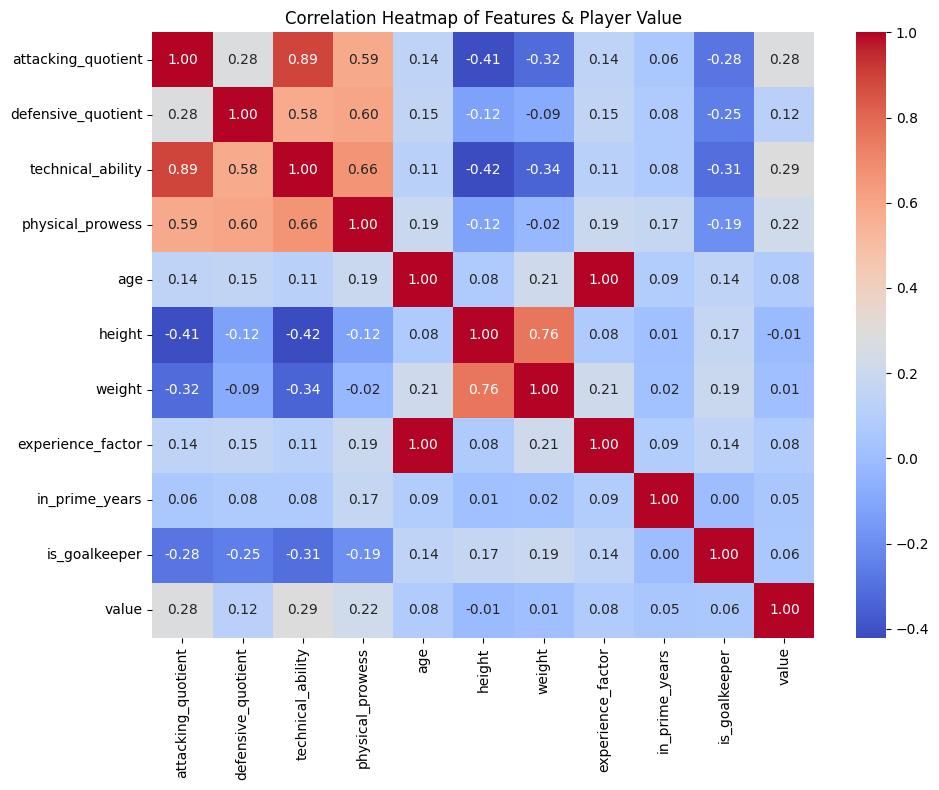

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[features + ['value']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features & Player Value')
plt.tight_layout()
plt.show()


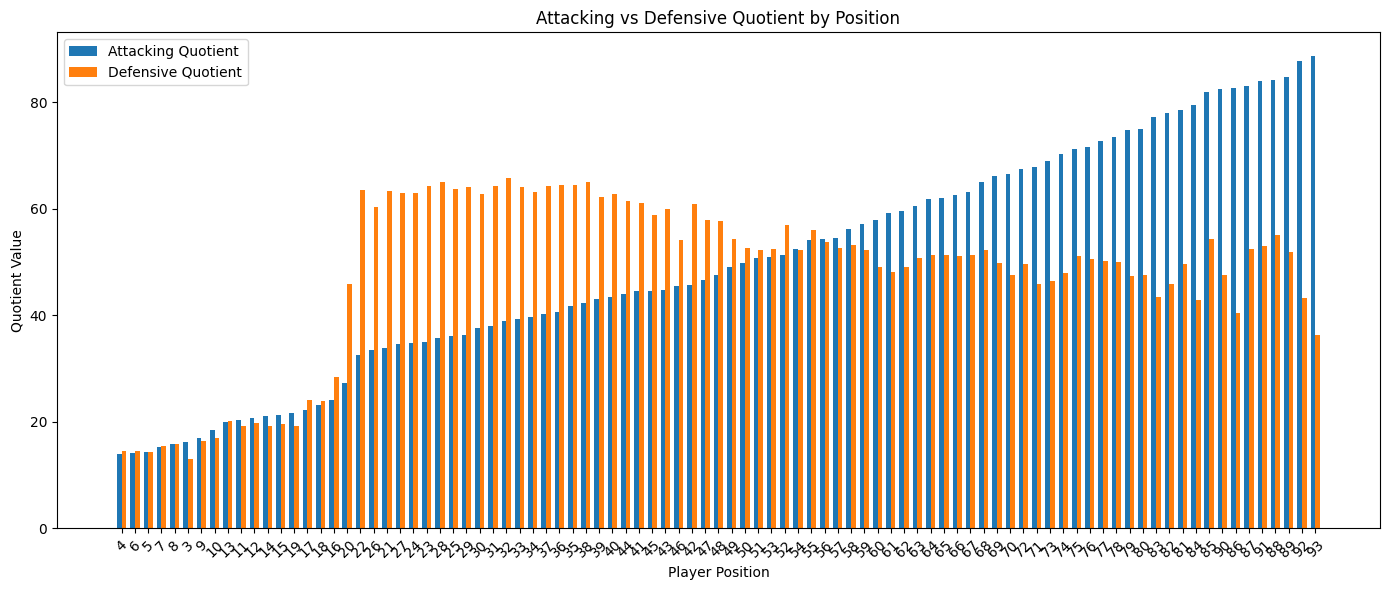

In [ ]:
position_stats = df.groupby('att_position')[['attacking_quotient', 'defensive_quotient']].mean().reset_index()
position_stats = position_stats.sort_values('attacking_quotient')

plt.figure(figsize=(14, 6))
x = np.arange(len(position_stats))
width = 0.35

plt.bar(x - width/2, position_stats['attacking_quotient'], width, label='Attacking Quotient')
plt.bar(x + width/2, position_stats['defensive_quotient'], width, label='Defensive Quotient')

plt.xlabel('Player Position')
plt.ylabel('Quotient Value')
plt.title('Attacking vs Defensive Quotient by Position')
plt.xticks(x, position_stats['att_position'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


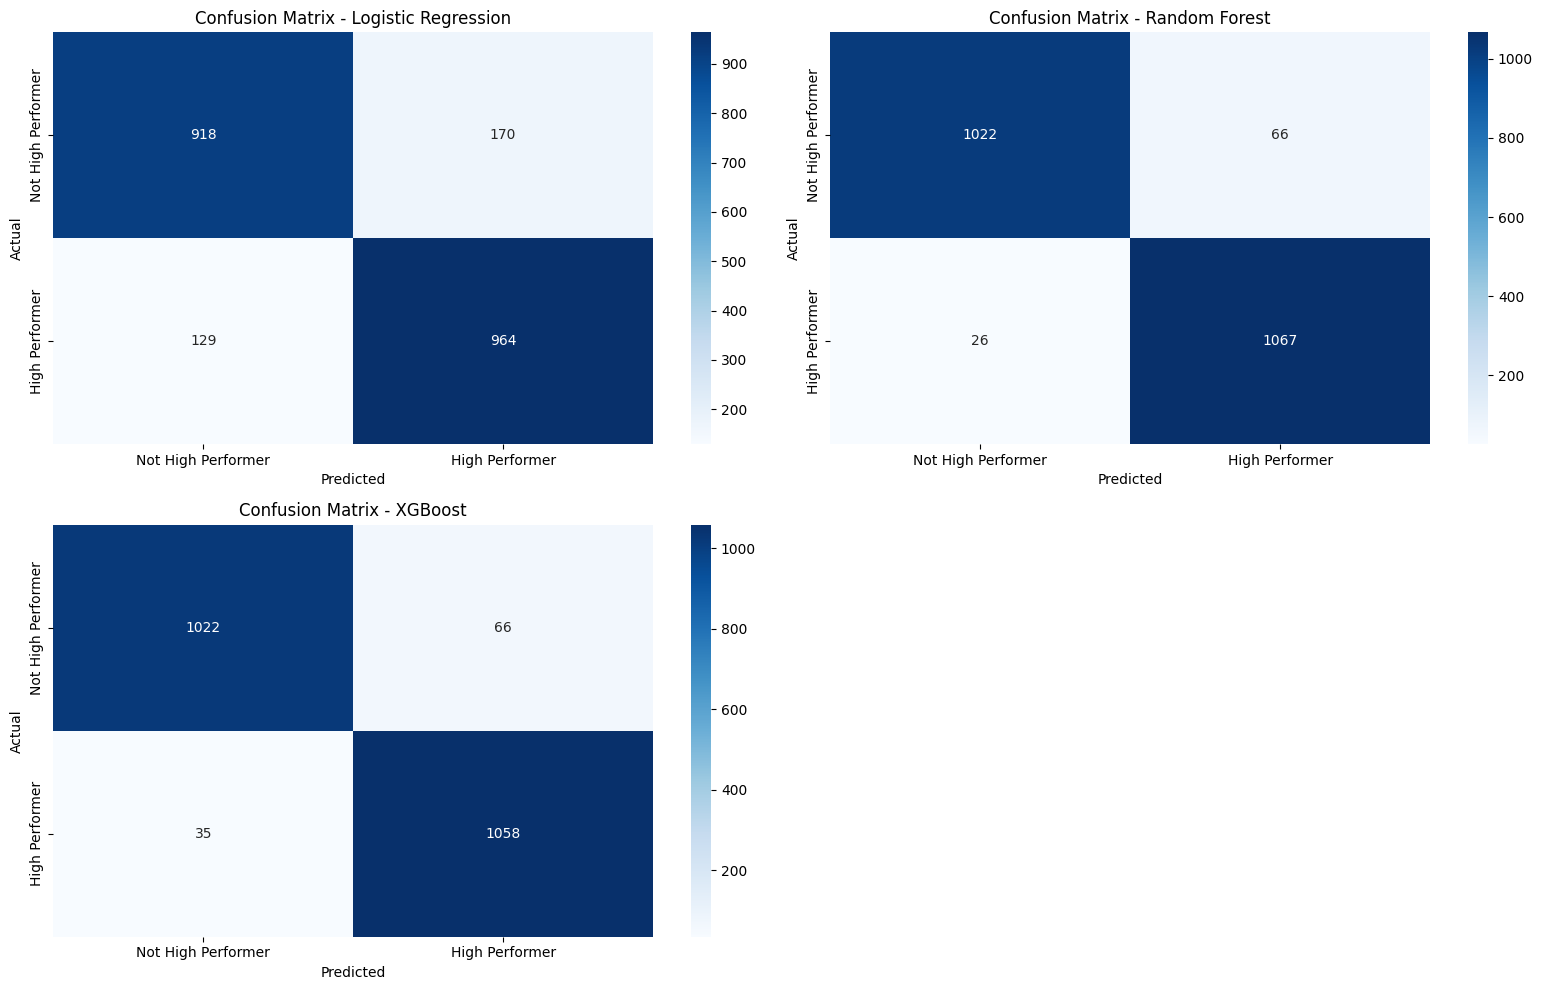

In [ ]:
plt.figure(figsize=(16, 10))
for i, (name, result) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not High Performer', 'High Performer'],
                yticklabels=['Not High Performer', 'High Performer'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()


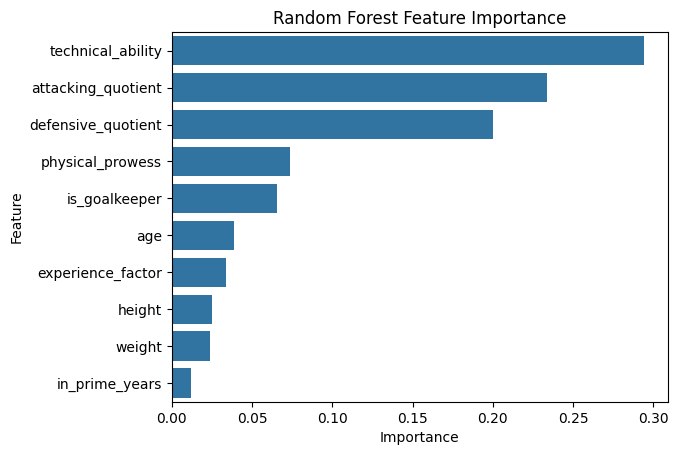

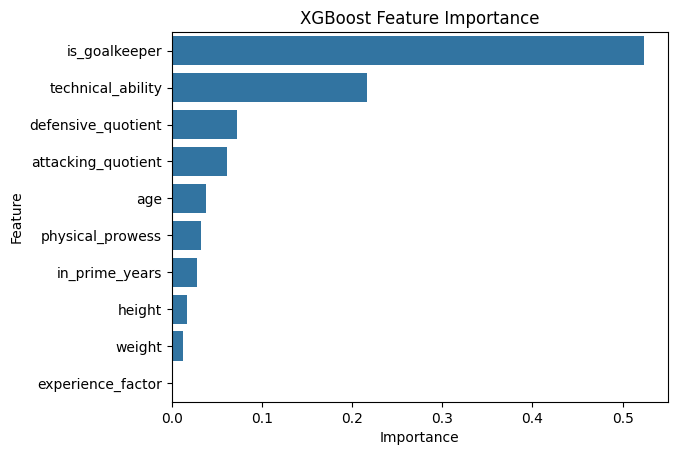

In [ ]:
# Random Forest Feature Importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_rf)
plt.title('Random Forest Feature Importance')
plt.show()

# XGBoost Feature Importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_xgb)
plt.title('XGBoost Feature Importance')
plt.show()


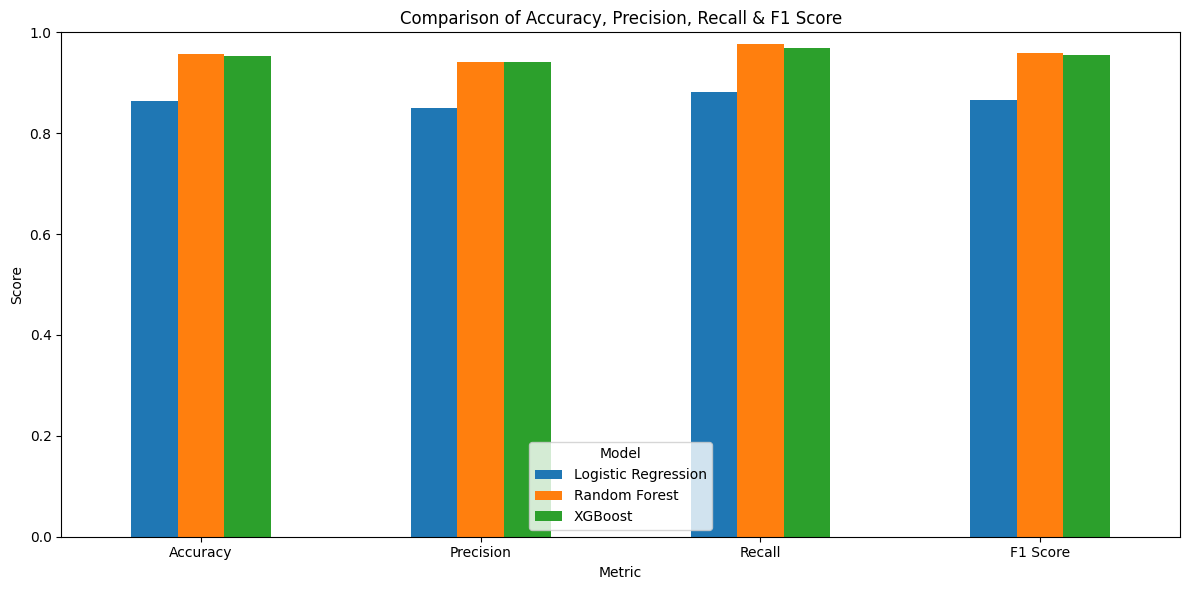

In [ ]:
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of Accuracy, Precision, Recall & F1 Score')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')